### Paper 3 : fitting simulated DRW and sinusoids  with Celerite  combination kernel 

https://github.com/RuthAngus/GPtutorial
https://github.com/RuthAngus/GPtutorial/blob/master/Simple_george_demo.ipynb

Visualising kernels: http://dfm.io/gp.js/


* Simulating a DRW light curve (parametrized by asymptotic amplitude SF_inf, and characteristic timescale tau )
* adding a sinusoidal modulation (parametrized by amplitude A, period P). 

With tau  = 100 days, and regular sampling every dt = 5 days  , we explore regimes from A << SF_inf,  to A ~ SF_inf , and from P << tau, to P >> tau : 
A \in { 0.01,  0.1,  0.25,  0.5, 0.75 } SF_infty       \cross  P \in { 0.25,  1 ,  4 } \tau   

We then test the combination kernel GP on SDSS S82 light curves of spectroscopically selected QSO from Schneider+2007 to measure completeness. 

**Aim** : We propose a new application for Gaussian Processes combination kernels for detecting DRW light curves with sinusoidal modulation.  Combination kernels in GP models have been successfully employed to study the variability of  spotted, rotating stars (Angus+2017). A model can be expressed in that framework as a combination of Gaussian kernels, i.e. functions describing covariance between pairs of points as a mode of their separation in a chosen metric. For light curves the time difference between pairs of observations can be the most useful metric. Thus the kernel f(delta x)  us a function of time difference delta( t ) . Gaussian Processes can successfully recover the DRW signal, represented by the Real Term kernel in Celerite, fDRW.  We can combine that kernel with  oscillatory term fSHO.  Thus a combination kernel consists of two kernels with relative amplitudes A and B ,  fCOMB = A fDRW + B fSHO . A scientific application would be to search for binary SMBH where the orbital motion modulates the DRW signal from accretion disks ( amplitude A similar to B) ,  or distinguish between a signal from a Quasar ( dominant amplitude A ) or an RR Lyrae / EB (dominant amplitude B).  

TICKETS : 
* define the kernel that would be a combination of DRW and aperiodic ... ( most likely SHOTerm  )  : check out https://github.com/dfm/rotate/blob/master/demo.ipynb
* simulate DRW with sinusoidal modulation , explore the parameter space : plot the light curve and fit,  re-use the existing code ( in  DRW_Celerite/code/Celerite_fit_simulated_data.ipynb ) 

In [1]:
import numpy as np 
import os 
import datetime
import celerite
from celerite import terms
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from scipy.optimize import minimize
from matplotlib import rcParams   

rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

 MacLeod+2010  talks about ACF for DRW model being 

  $ACF(\Delta t) = \exp(-|\Delta  t|/\tau)$

And the functional form of $SF$ : 

  $SF(\Delta t) = SF_{\infty} (1 - e^{-|\Delta  t|/\tau}) ^{1/2}$
  
Zu+2013  notes that the covariance function for DRW is :

  $S_{DRW}(\Delta t) = \sigma^{2} \exp(-|\Delta  t|/\tau) $
  
Now how does that relate to celerite kernels ?  http://celerite.readthedocs.io/en/latest/python/kernel/

In [2]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag





In [3]:
### One way of simulating DRW ...

tau_in = 100
sigma_in = 0.2 
yerr =  0.001
length = 10  # lc length in terms of timescale 
delta_time = 10

t_min = 1
t_max = t_min + length*tau_in

Npts= int(np.floor((t_max - t_min) / delta_time))
# we determine number of points by responding to the delta_time chosen...
regular_grid = True 
if regular_grid : 
    # evenly spaced sampling within the chosen interval 
    print('Using regular sampling')
    t = np.arange(t_min, t_max, delta_time)
else :
    # random sampling with the chosen number of points ... 
    # The input coordinates must be sorted
    print('Using random sampling')
    t = np.sort(np.random.uniform(t_min, t_max, Npts)) 

SF_inf = sigma_in * np.sqrt(2)
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

Using regular sampling


<Container object of 3 artists>

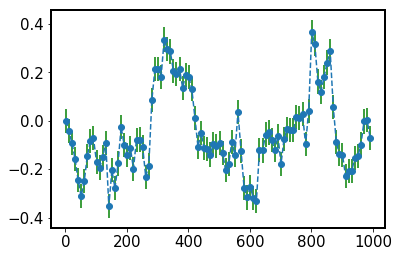

In [5]:
%matplotlib inline
plt.errorbar(t,y, 50*yerr,fmt='--o' ,ecolor='g')

Add Gaussian noise : 

Input tau is  100 , sigma  0.2


<Container object of 3 artists>

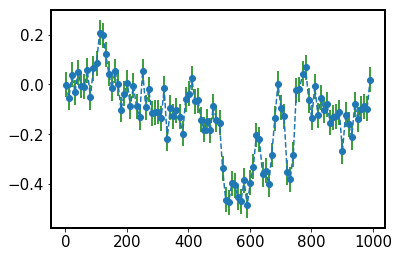

In [6]:
# Add to the ideal light curve a Gaussian Noise 
stdev = 0.001
noise = np.random.normal(loc=0,scale=stdev,size=len(t))
y_obs = y + noise  # eq.2 Kozlowski+2017

# the uncertainty on each measurement : 
# homoscedastic, i.e. same errors for all points 
yerr = np.ones_like(t)* stdev 
print('Input tau is ', tau_in, ', sigma ', sigma_in)

%matplotlib inline
plt.errorbar(t,y_obs, 50*yerr,fmt='--o' ,ecolor='g')

Add sinusoidal modulation  :

<Container object of 3 artists>

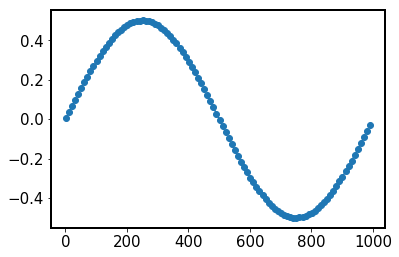

In [7]:
# https://www.cs.sfu.ca/~tamaras/sinusoids318/sinusoids318_4up.pdf 
A = 0.5
period = 1000
omega = 2*np.pi / period
#t = np.linspace(0,1000,1000)
y_sin = A*np.sin(omega*t)
plt.errorbar(t,y_sin,yerr, fmt='--o')


Combine the two : 

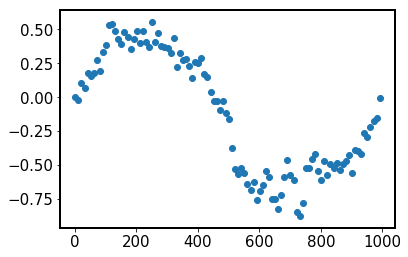

In [8]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
#rcParams["savefig.dpi"] = 150
#rcParams["figure.dpi"] = 150
y_comb = y_sin + y_obs 
plt.scatter(t,y_comb)

Define kernel that corresponds to the sinusoidal function ('correct' one ) : 
    
 $y(t) = A \sin{(\omega t)}$, 
    
 $k(\tau) = \Phi_{ff}(\tau) = \frac{A\omega}{2\pi} \int_{0}^{2\pi/\omega}{\sin{(\omega t)}\sin{(\omega(t+\tau))}\mbox{dt}} = \frac{A}{2}\cos{(\omega \tau)}$
 
 that is, we can use the \verb|ComplexTerm|: (eq.7 in Foreman-Mackey+2017) 
 
 $ k(\tau) = \frac{1}{2}\,\left[(a_j + i b_j)\,e^{-(c_j+i d_j)\,\tau}
     + (a_j - i b_j)\,e^{-(c_j- i d_j)\,\tau}\right]$
     
 setting  $b_{j}=0$, $c_{j}=0$ : 
 
 $k(\tau) = a_{j}\cos(d_{j}\tau)$
 
 where now  $a_{j} \equiv A/2$, and $d_{j} \equiv \omega$

plot the kernel : 

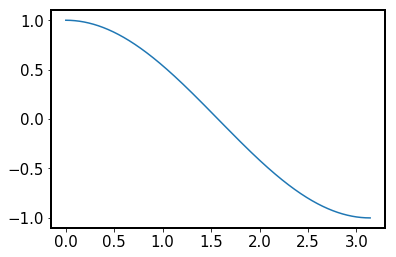

In [9]:
%matplotlib inline
tau  = np.linspace(0,np.pi,1000)
plt.plot(tau, np.cos(tau))

Test the example from Celerite docs, but remove the trend, to make it an utterly plain sinusoid

Initial log likelihood: 3.49672874031387
      fun: -52.87084049338358
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.53477231e-04,  -1.53477231e-04,   1.45519152e-03,
         3.52429197e-04,   4.87784746e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 588
      nit: 66
   status: 0
  success: True
        x: array([  1.65758758,  -8.17836298, -15.        ,  13.61128677,   0.6965706 ])


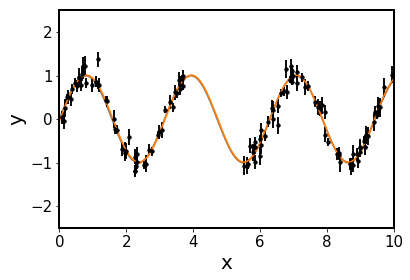

In [11]:
## test the website example .... 
# 

import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
#y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))
#y =  np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))
period=  np.pi
omega = 2*np.pi / period
y =  np.sin(omega*t) + yerr * np.random.randn(len(t))

#

true_t = np.linspace(0, 10, 5000)
#true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)
#true_y =  np.sin(3*true_t + 0.1*(true_t-5)**2)
true_y =  np.sin(omega*true_t)


  
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)


gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))


from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, 
             args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

Try fitting the Celerite-based example with the kernel that should correspond to the true sinusoid...

True A= 1  true omega= 2.0
Initial log likelihood: -3.9800572002190506
      fun: -50.767742140140854
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -9.66338121e-05,   4.54747351e-05,  -1.34889433e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 200
      nit: 37
   status: 0
  success: True
        x: array([ -0.7028845 , -18.43459277,   0.69563474])
fit A= 0.990309936954 fit omega= 2.00498131547


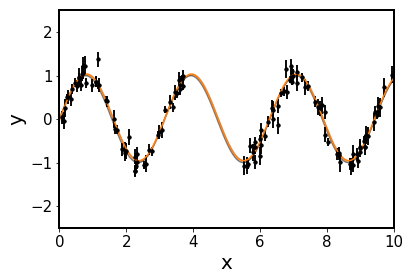

In [12]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted

yerr = np.random.uniform(0.08, 0.22, len(t))
noise = yerr * np.random.randn(len(t))
# pure sinusoid ... 
period=  np.pi
omega = 2*np.pi / period
A = 1
print('True A=', A, ' true omega=', omega)
y =  np.sin(omega*t) + noise

true_t = np.linspace(0, 10, 5000)
true_y =  np.sin(omega*true_t)


plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

import celerite
from celerite import terms

# The 'correct' kernel for a sinusoid... 
# log_a = log (A/2) : fit for amplitude 
# log_b = log_0 = undefined ... perhaps set log_b = 0 ? 
# log_c = log_0 /... set log_c = 0 ? 
# log_d = log_d =  log(omega) : keep as free parameter 
#

kernel = terms.ComplexTerm(log_a = np.log(A/2) ,log_c = 0,
                           log_d = np.log(omega))

# freeze the parameters that we don't want to fit for 
#kernel.freeze_parameter("log_b")
#kernel.freeze_parameter("log_c")

gp = celerite.GP(kernel, mean = np.mean(y))
gp.compute(t , yerr)

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()


gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))


from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, 
             args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);



res = gp.get_parameter_dict()
fit_amplitude = 2 * np.exp(res['kernel:log_a'])
fit_omega = np.exp(res['kernel:log_d'])

print('fit A=', fit_amplitude, 'fit omega=', fit_omega)

Plot true kernel and the fitted kernel : 

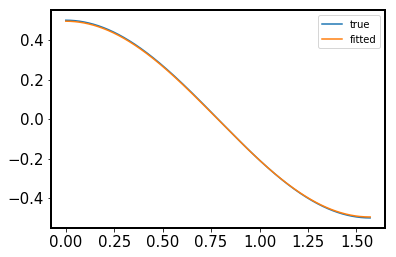

In [13]:
tau  = np.linspace(0,np.pi/2,1000)
k_true = (A/2) * np.cos(omega*tau)
a = np.exp(res['kernel:log_a'])
c = np.exp(res['kernel:log_c'])
d = np.exp(res['kernel:log_d'])
k_fitted = a * np.cos(d*tau) * np.exp(-c*tau)
plt.plot(tau,k_true, label='true')
plt.plot(tau,k_fitted, label='fitted')
plt.legend()

Since fitting a well-sampled sinusoid with the correct kernel gives a satisfactory result,  lets combine the sinusoid with DRW :  

True A= 1  true omega= 2.0


<Container object of 3 artists>

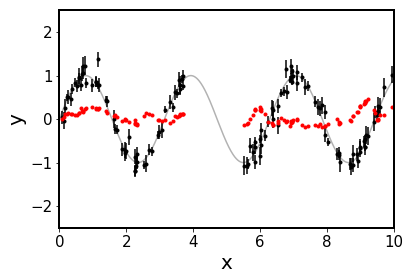

In [65]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted

yerr = np.random.uniform(0.08, 0.22, len(t))

# pure sinusoid ... 
period=  np.pi
omega = 2*np.pi / period
A=1
print('True A=', A, ' true omega=', omega)
y =  np.sin(omega*t) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y =  np.sin(omega*true_t)


plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);



plt.errorbar(t,y_DRW, yerr=0.001, fmt='.', capsize=0, color='red')

tau_in= 1 sigma_in= 1
      fun: 20.545139423071788
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.84217094e-06,  -5.68434189e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 8
   status: 0
  success: True
        x: array([-0.41195936, -0.00097731])
tau_fit= 1.00097778526 sigma_fit= 0.813849612033


(0, 10)

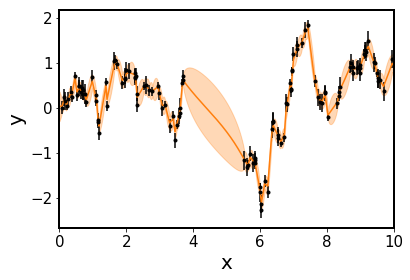

In [17]:
# Try fitting separately for just DRW with the DRW kernel : 
# the underlying DRW signal 
tau_in = 1  
# since t is from 1 to 10 , so that 
# the light curve is ten times longer 
# than the input timescale 

sigma_in = 1  # this controls the amplitude 
SF_inf = sigma_in * np.sqrt(2)

# simulate DRW on the same epochs as the sinusoid above 
y_DRW = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)

# the true DRW kernel 
kernel = terms.RealTerm(log_a = 2 * np.log10(sigma_in) , log_c = np.log10(1/tau_in))
print('tau_in=', tau_in,  'sigma_in=', sigma_in)
gp = celerite.GP(kernel)
gp.compute(t, yerr)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y_DRW, gp))
gp.set_parameter_vector(r.x)
print(r)
res = gp.get_parameter_dict()
tau_fit = np.exp(-res['kernel:log_c']) # == 1.0 / np.exp(res['kernel:log_c'])
sigma_fit = np.exp(0.5*res['kernel:log_a']) # == np.sqrt(np.exp(res['kernel:log_a']))
print('tau_fit=',tau_fit, 'sigma_fit=',sigma_fit)

# plot the prediction 
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y_DRW, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.errorbar(t, y_DRW, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
#plt.ylim(-0.3, 0.3);

                                                                                                                                                                                                                                           

Combine the sinusoid and DRW ( use the same DRW while varying other params): 



In [88]:
# the gappy time series, from 0 to 10 in time units 
np.random.seed(42)
t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted

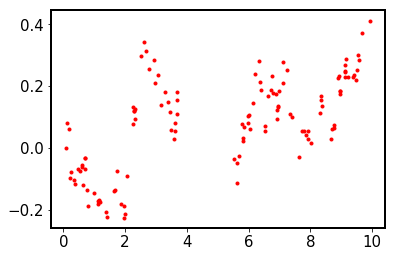

In [90]:
tau_in = 1
sigma_in = 0.2

SF_inf = sigma_in * np.sqrt(2)
y_DRW = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)
plt.errorbar(t,y_DRW, yerr=0.001, fmt='.', capsize=0, color='red')
np.save('y_DRW_tau-1_sigma-0.2', y_DRW)

In [92]:
y_DRW = np.load('y_DRW_tau-1_sigma-0.2.npy')

<Container object of 3 artists>

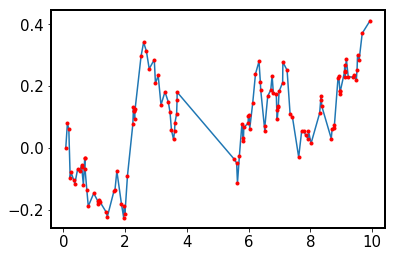

In [99]:
# ensure that the saved one is exactly the same 
# as the one that we simulated ./..

# it  is the true underlying time series  -  no error included\
plt.plot(t,y_DRW)
plt.errorbar(t,y_DRW, yerr=0.001, fmt='.', capsize=0, color='red')

(array([  4.,   3.,   4.,  14.,  36.,  23.,  16.,  14.,   8.,   3.]),
 array([-0.53286646, -0.4325757 , -0.33228494, -0.23199418, -0.13170341,
        -0.03141265,  0.06887811,  0.16916887,  0.26945964,  0.3697504 ,
         0.47004116]),
 <a list of 10 Patch objects>)

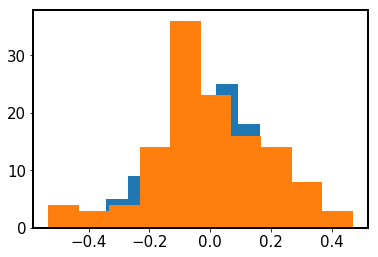

In [110]:


yerr = np.random.randn(len(t)) * yerr_uniform
plt.hist(yerr)
yerr = np.random.normal(loc=0,scale=0.2,size=len(t))
plt.hist(yerr)

In [ ]:

# the range of error bars :  the uniform distribution
# spread over the G univariate "normal" (Gaussian)
# distribution of mean 0 and variance 1 
#yerr_uniform = np.random.uniform(0.08, 0.0, len(t))
#yerr = np.random.randn(len(t)) * yerr_uniform

yerr = 0.01 * np.ones_like(t)
noise = np.random.randn(len(t)) * yerr
# normal(loc=0,scale=stdev,size=len(t))

# pure sinusoid ... 
period=  np.pi
omega = 2*np.pi / period
A=1
print('True A=', A, ' true omega=', omega)
y_sin =  np.sin(omega*t) 

# combine sinusoid, DRW, and add error 
y_comb = y_DRW + y_sin + noise

#true_t = np.linspace(0, 10, 5000)
#true_y =  np.sin(omega*true_t) 
#plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
#plt.errorbar(t, y_comb, yerr=yerr, fmt=".k", capsize=0)

# the DRW part 
kernel = terms.RealTerm(log_a = 2 * np.log10(sigma) , log_c = np.log10(1/tau))

# the sinusoidal part 
kernel += terms.ComplexTerm(log_a = np.log(A/2) ,log_c = 0,
                           log_d = np.log(omega))

print('tau_in=', tau,  'sigma_in=', sigma)
gp = celerite.GP(kernel,mean=np.mean(y_comb))
gp.compute(t,yerr)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y_comb, gp))
gp.set_parameter_vector(r.x)
print(r)
res = gp.get_parameter_dict()
tau_fit = np.exp(-res['kernel:terms[0]:log_c']) # == 1.0 / np.exp(res['kernel:log_c'])
sigma_fit = np.exp(0.5*res['kernel:terms[0]:log_a']) # == np.sqrt(np.exp(res['kernel:log_a']))
print('tau_fit=',tau_fit, 'sigma_fit=',sigma_fit)

A_fit = 2 * np.exp(res['kernel:terms[1]:log_a'])
omega_fit = np.exp(res['kernel:terms[1]:log_d'])
print('A_fit=',A_fit,  'omega_fit=',omega_fit )

# plot the prediction 
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y_comb, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.errorbar(t, y_comb, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

In [ ]:
This appears good, although I do not see why 

In [78]:
res

OrderedDict([('kernel:terms[0]:log_a', -3.6521878688517928),
             ('kernel:terms[0]:log_c', 0.92401307403256272),
             ('kernel:terms[1]:log_a', -0.64083409122695179),
             ('kernel:terms[1]:log_c', -15.83451973494399),
             ('kernel:terms[1]:log_d', 0.70883437921170811)])

**RealTerm** :  

covariance $k(\tau) = a_j\,e^{-c_j\,\tau}$   


**SHOTerm** : 
    
FT(covariance) $S(\omega) = \sqrt{\frac{2}{\pi}} \frac{S_0\,\omega_0^4}
    {(\omega^2-{\omega_0}^2)^2 + {\omega_0}^2\,\omega^2/Q^2}$

In [56]:
# the DRW  RealTerm kernel
tau = tau_in
sigma = sigma_in 
kernel = terms.RealTerm(log_a = 2 * np.log10(sigma) , log_c = np.log10(1/tau))

# add the SHOTerm periodic kernel :stochastically-driven, damped harmonic oscillator
flux  = y_comb
log_var = np.log(np.var(flux))
kernel += terms.SHOTerm(
    log_S0=log_var,
    log_Q=-0.5*np.log(2),
    log_omega0=np.log(2*np.pi/10.0),
    bounds=dict(
        log_S0=(-20.0, 20.0),
        log_omega0=(np.log(2*np.pi/80.0), np.log(2*np.pi/2.0))
    ))

# set the kernel 
gp = celerite.GP(kernel)
gp.compute(t)

from scipy.optimize import minimize
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y_comb, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -104.41990026708892
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  3.41060513e-05,   9.94759830e-05,  -1.59445790e-03,
        -2.11741735e-03,   7.75156650e-01])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 582
      nit: 66
   status: 0
  success: True
        x: array([-12.67327524,  -4.94119317,   3.35815838,  -3.06210736,  -2.54414957])


In [57]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_a', -12.673275235410419),
             ('kernel:terms[0]:log_c', -4.941193168486703),
             ('kernel:terms[1]:log_S0', 3.3581583784306845),
             ('kernel:terms[1]:log_Q', -3.0621073638725282),
             ('kernel:terms[1]:log_omega0', -2.5441495682645363)])

In [58]:
x = np.linspace(0, 1000, 5000)
pred_mean, pred_var = gp.predict(y_comb, x, return_var=True)
pred_std = np.sqrt(pred_var)

In [64]:
pred_mean

array([ 0.00417604,  0.00408948,  0.00396718, ..., -0.23145983,
       -0.23128937, -0.23111903])

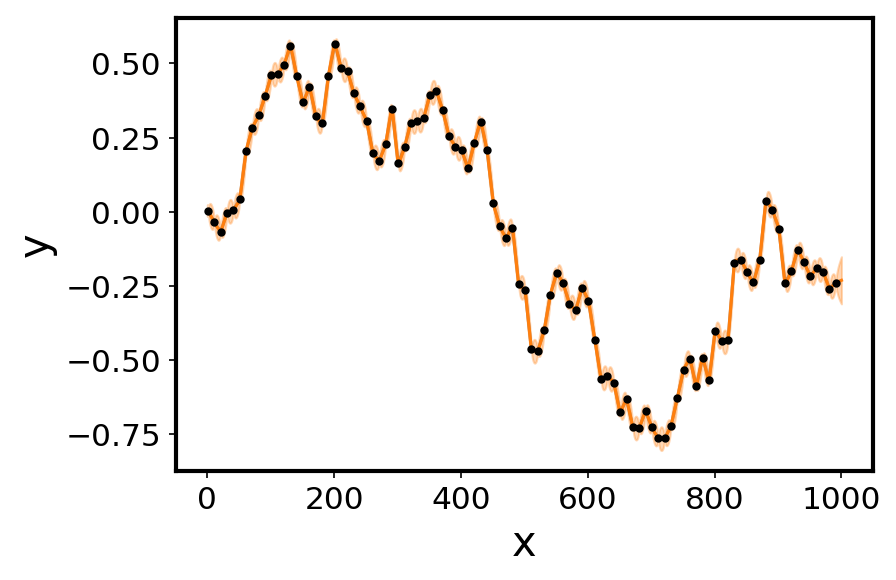

In [71]:
color = "#ff7f0e"
plt.plot(t, y_comb, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y_comb, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
#plt.xlim(0, 10)
#plt.ylim(-2.5, 2.5);

In [ ]:
# Failed fitting case ...
# seems that restricting the kernel doesn't help 
# anything at all...

A = 0.5
period = 200
omega = 2*np.pi / period
print('true A', A, 'true omega= ', omega)
t = np.linspace(0,1000,200)
y_sin = A*np.sin(omega*t)
yerr = 0.01 * np.ones_like(t)

# Fit pure sinusoid with the 'correct' kernel : 
# log_a = log (A/2) : fit for amplitude 
# log_b = log_0 = undefined ... perhaps set log_b = 0 ? 
# log_c = log_0 /... set log_c = 0 ? 
# log_d = log_d =  log(omega) : keep as free parameter 
#
kernel = terms.ComplexTerm(log_a = np.log(A/2) , log_b = 0, 
                           log_c = 0 , log_d = np.log(omega))

# freeze the parameters that we don't want to fit for 
kernel.freeze_parameter("log_b")
kernel.freeze_parameter("log_c")

gp = celerite.GP(kernel, mean = np.mean(y_sin))
gp.compute(t , yerr)

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
a_true = A/2.0
d_true = omega
log_a_bounds = (np.log(0.2), np.log(2))
log_d_bounds = (np.log(0.2*omega), np.log(2*omega))

bounds = [log_a_bounds, log_d_bounds]
#bounds = gp.get_parameter_bounds()
r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y_sin, gp))
gp.set_parameter_vector(r.x)

res = gp.get_parameter_dict()
fit_amplitude = 2 * np.exp(res['kernel:log_a'])
fit_omega = np.exp(res['kernel:log_d'])

# prediction space :  denser than the data space 
x = np.linspace(0, 1000, 5000)
pred_mean, pred_var = gp.predict(y_sin, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(t, y_sin, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y_sin, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

print('fit A=', fit_amplitude, 'fit omega=', fit_omega)

# Use a completely different kernel ...

Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

gp = celerite.GP(kernel,mean=np.mean(y_sin))
gp.compute(t, yerr)

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y_sin, gp))
gp.set_parameter_vector(r.x)

res = gp.get_parameter_dict()

# prediction space :  denser than the data space 
x = np.linspace(0, 1000, 2000)
pred_mean, pred_var = gp.predict(y_sin, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(t, y_sin, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y_sin, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

